In [1]:
import os
# import b3d
import numpy as np
import numpy as np
import h5py
import matplotlib.pyplot as plt
import trimesh

In [2]:
%matplotlib widget

In [3]:
# paths for reading physion metadata
physion_assets_path = '/home/haoliangwang/data/physion_hdf5/dominoes_all_movies'

stim_name = 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0010'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

video_file_path = os.path.join(physion_assets_path,
    f"{stim_name}_img.mp4",
)

In [4]:
def scale_mesh(vertices, scale_factor):
    vertices[:, 0] *= scale_factor[0]
    vertices[:, 1] *= scale_factor[1]
    vertices[:, 2] *= scale_factor[2]
    # vertices[:,[2,1]] = vertices[:,[1,2]]
    return vertices

def compute_linear_velocity(last, now, dt):
    vel = (now-last)/dt
    return vel

## test whether linear velocity is calculated using the center_cam0

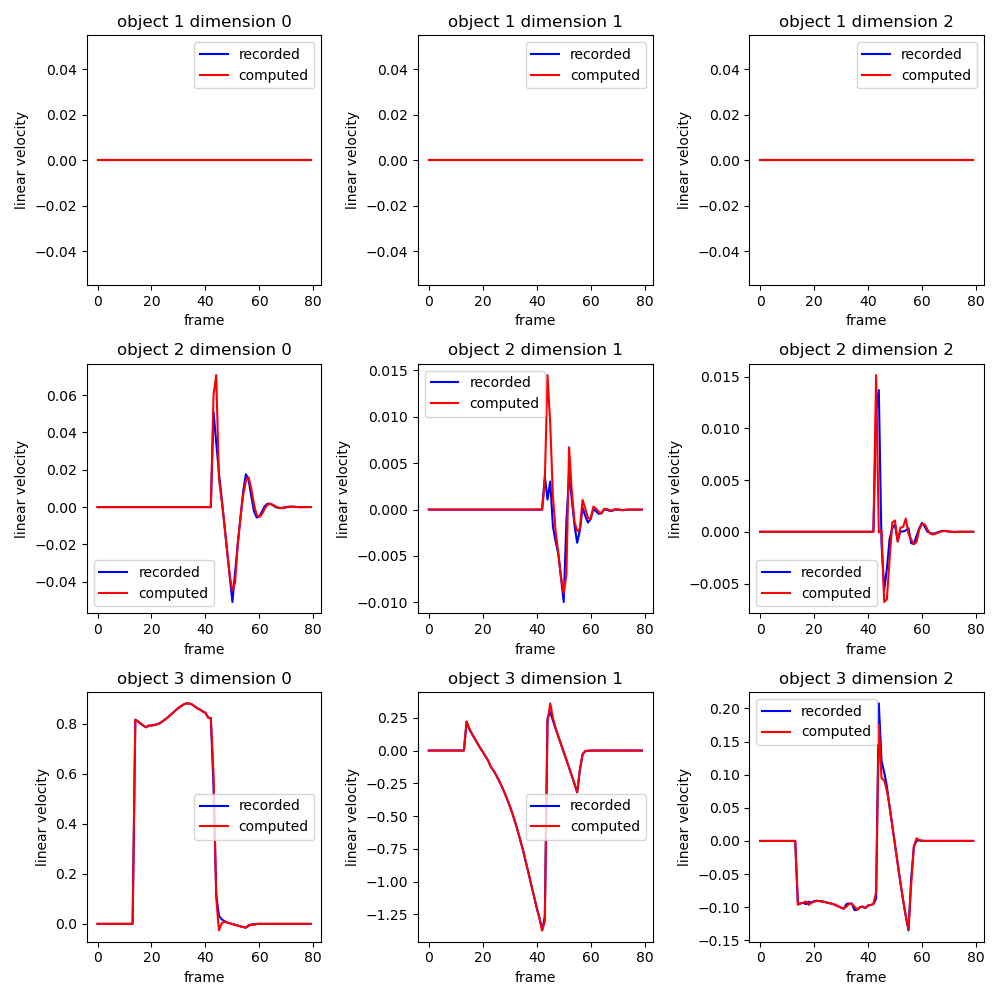

In [7]:
# fps = b3d.io.utils.load_video_info(video_file_path).fps
fps = 100
window_size = 1
delta_t = window_size/fps
PLOTS_PER_ROW = 3

with h5py.File(hdf5_file_path, "r") as f:
    model_names = np.array(f['static']['model_names'])
    object_ids = np.array(f["static"]["object_ids"])
    distractors = (
        np.array(f["static"]["distractors"])
        if np.array(f["static"]["distractors"]).size != 0
        else []
    )
    occluders = (
        np.array(f["static"]["occluders"])
        if np.array(f["static"]["occluders"]).size != 0
        else []
    )
    distractors_occluders = np.concatenate([distractors, occluders])
    if len(distractors_occluders):
        object_ids = object_ids[: -len(distractors_occluders)]
    
    fig, axs = plt.subplots(len(object_ids), PLOTS_PER_ROW, figsize=(10, 10))

    for i, obj_idx in enumerate(object_ids):
        recorded = []
        computed = []
        for key in f['frames'].keys():
            lin_vel = np.array(f['frames'][key]['objects']['velocities'])
            center_now = np.array(f['frames'][key]['objects']['center_cam0'])
            # if obj_idx == 2:
            #     print(key, center_now[obj_idx], lin_vel[obj_idx])
            if int(key) < window_size:
                continue
            frame_idx = int(key)
            center_last = np.array(f['frames'][str(frame_idx-window_size).zfill(4)]['objects']['center_cam0'])
            linear_velocity = compute_linear_velocity(center_last[i], center_now[i], delta_t)
            recorded.append(lin_vel[i])
            computed.append(linear_velocity)
            # if obj_idx == 2:
            #     print(key, linear_velocity, lin_vel[obj_idx])
        recorded = np.array(recorded)
        computed = np.array(computed)
        frames = [j for j in range(computed[:,0].shape[0])]
        for dim in range(PLOTS_PER_ROW):
            axs[i][dim].plot(frames, recorded[:,dim], 'blue', label='recorded')
            axs[i][dim].plot(frames, computed[:,dim], 'red', label='computed')
            axs[i][dim].set_xlabel("frame")
            axs[i][dim].set_ylabel("linear velocity")
            axs[i][dim].legend()
            axs[i][dim].set_title(f'object {obj_idx} dimension {dim}')
    plt.tight_layout()
    plt.show()

NameError: name 'b3d' is not defined

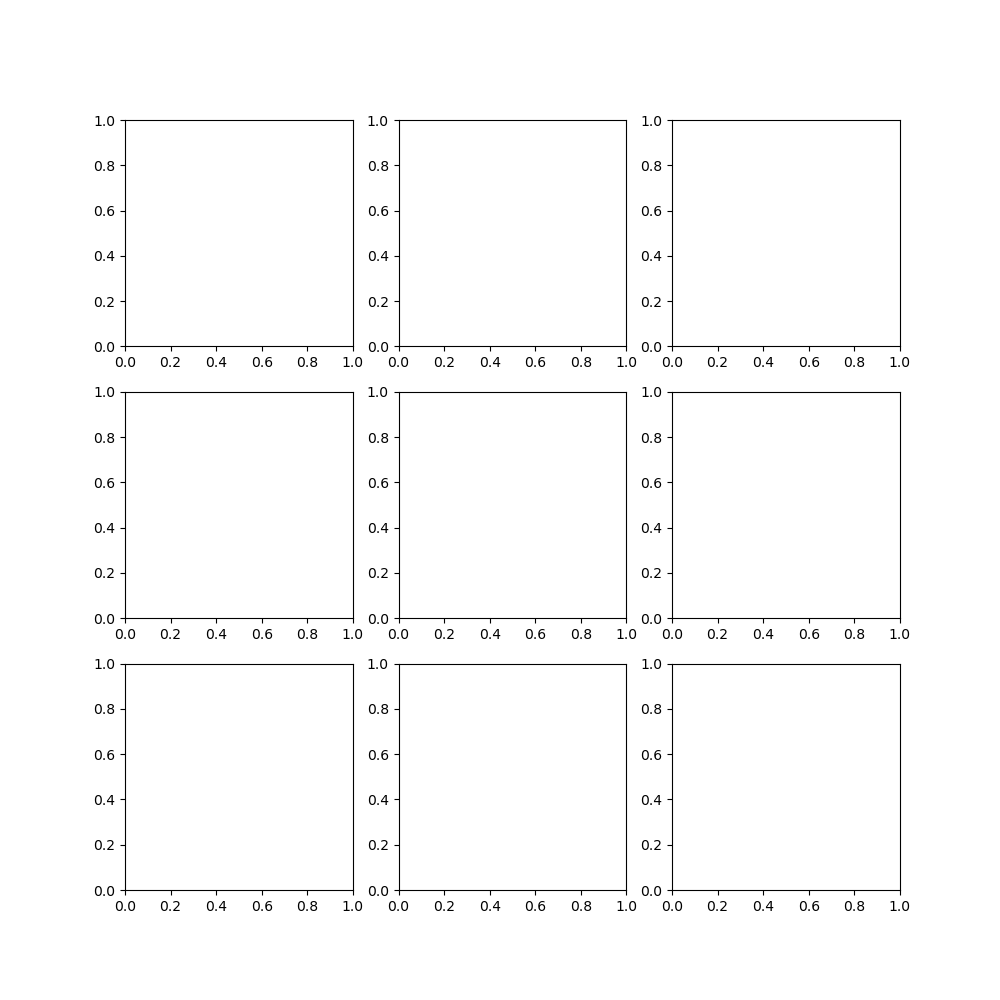

In [6]:
# fps = b3d.io.utils.load_video_info(video_file_path).fps
fps = 100
window_size = 1
delta_t = window_size/fps
PLOTS_PER_ROW = 3

with h5py.File(hdf5_file_path, "r") as f:
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else None if np.array(f['static']['distractors']).size != 0 else None
    occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else None if np.array(f['static']['occluders']).size != 0 else None
    
    distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
    excluded_model_ids = distractor_ids+occluder_ids
    included_model_names = [model_names[idx] for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    included_model_ids = [object_ids[idx]-1 for idx in range(len(object_ids)) if idx not in excluded_model_ids]

    scales = np.array(f['static']['scale'])
    meshes_faces = [np.array(f['static']['mesh'][f'faces_{idx}']) for idx in range(len(object_ids))]
    meshes_vertices = [np.array(f['static']['mesh'][f'vertices_{idx}']) for idx in range(len(object_ids))]
    object_scales = [scale for idx, scale in enumerate(scales) if idx in included_model_ids]
    object_meshes = [(scale_mesh(vertex, object_scales[idx]), face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in included_model_ids]
    
    fig, axs = plt.subplots(len(included_model_ids), PLOTS_PER_ROW, figsize=(10, 10))

    for obj_idx in included_model_ids:
        mesh = b3d.Mesh(vertices=object_meshes[obj_idx][0], faces=object_meshes[obj_idx][1], vertex_attributes=None)
        recorded = []
        computed = []
        for key in f['frames'].keys():
            if int(key) < window_size:
                continue
            frame_idx = int(key)
            
            position = np.array(f['frames'][key]['objects']['positions_cam0'])
            rotation = np.array(f['frames'][key]['objects']['rotations_cam0'])
            object_positions = np.asarray([pos for idx, pos in enumerate(position) if idx in included_model_ids])
            object_rotations = np.asarray([rot for idx, rot in enumerate(rotation) if idx in included_model_ids])
            object_pose = b3d.Pose(object_positions[obj_idx], object_rotations[obj_idx])

            mesh_transform = mesh.transform(object_pose)
            mesh_transform = trimesh.Trimesh(mesh_transform.vertices, mesh_transform.faces)
            center_now = mesh_transform.center_mass

            position = np.array(f['frames'][str(frame_idx-window_size).zfill(4)]['objects']['positions_cam0'])
            rotation = np.array(f['frames'][str(frame_idx-window_size).zfill(4)]['objects']['rotations_cam0'])
            object_positions = np.asarray([pos for idx, pos in enumerate(position) if idx in included_model_ids])
            object_rotations = np.asarray([rot for idx, rot in enumerate(rotation) if idx in included_model_ids])
            object_pose = b3d.Pose(object_positions[obj_idx], object_rotations[obj_idx])

            mesh_transform = mesh.transform(object_pose)
            mesh_transform = trimesh.Trimesh(mesh_transform.vertices, mesh_transform.faces)
            center_last = mesh_transform.center_mass

            # center_now = np.array(f['frames'][key]['objects']['center_cam0'])
            # center_last = np.array(f['frames'][str(frame_idx-window_size).zfill(4)]['objects']['center_cam0'])
            linear_velocity = compute_linear_velocity(center_last, center_now, delta_t)

            lin_vel = np.array(f['frames'][key]['objects']['velocities'])
            recorded.append(lin_vel[obj_idx])
            computed.append(linear_velocity)
        recorded = np.array(recorded)
        computed = np.array(computed)
        frames = [i for i in range(computed[:,0].shape[0])]
        for dim in range(PLOTS_PER_ROW):
            axs[obj_idx][dim].plot(frames, recorded[:,dim], 'blue', label='recorded')
            axs[obj_idx][dim].plot(frames, computed[:,dim], 'red', label='computed')
            axs[obj_idx][dim].set_xlabel("frame")
            axs[obj_idx][dim].set_ylabel("linear velocity")
            axs[obj_idx][dim].legend()
            axs[obj_idx][dim].set_title(f'object {obj_idx} dimension {dim}')
    plt.tight_layout()
    plt.show()

## test whether center_cam0 refers to the center of the bounding box

0.4999973 0.49999729435756135
0.49999753 0.49999751219368593
0.49999723 0.499997229335926
0.49999687 0.49999687731298126
0.4999966 0.49999660360602954
0.49999654 0.4999965243138434
0.49999648 0.4999964845204232
0.4999964 0.49999639252321004
0.4999964 0.49999639162342874
0.4999964 0.4999963923837772
0.49999636 0.4999963643591989
0.4999964 0.49999639567611937
0.49999642 0.49999643744862426
0.49999642 0.49999643399740723
0.5283991 0.5283990888353058
0.55632704 0.5563270695208256
0.584255 0.5842549834908188
0.612183 0.6121830067161166
0.64213914 0.6421391350703585
0.6721022 0.6721021819484835
0.70206535 0.7020653071324289
0.7320286 0.7320286590632853
0.7619921 0.7619921043328903
0.7919558 0.7919558394154673
0.82191974 0.8219197640117457
0.8518839 0.8518838740998479
0.8818482 0.8818482088647188
0.91181296 0.9118129499044911
0.94177794 0.9417779748622415
0.9717432 0.9717432217524299
1.0017087 1.0017088096982585
1.0316747 1.031674702897958
1.061641 1.0616409554491901
1.0916076 1.0916075583777

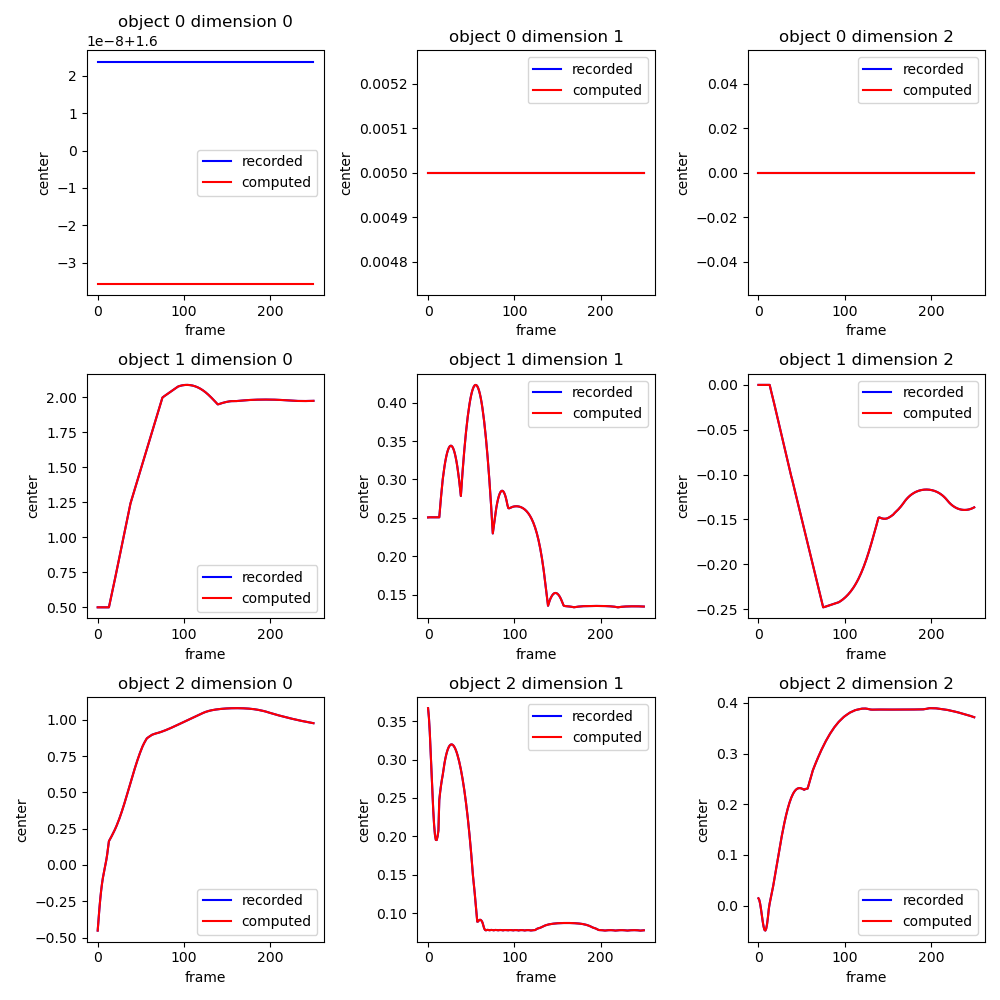

In [6]:
with h5py.File(hdf5_file_path, "r") as f:
    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else None if np.array(f['static']['distractors']).size != 0 else None
    occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else None if np.array(f['static']['occluders']).size != 0 else None
    
    distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
    excluded_model_ids = distractor_ids+occluder_ids
    included_model_names = [model_names[idx] for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    included_model_ids = [object_ids[idx]-1 for idx in range(len(object_ids)) if idx not in excluded_model_ids]

    scales = np.array(f['static']['scale'])
    meshes_faces = [np.array(f['static']['mesh'][f'faces_{idx}']) for idx in range(len(object_ids))]
    meshes_vertices = [np.array(f['static']['mesh'][f'vertices_{idx}']) for idx in range(len(object_ids))]
    object_scales = [scale for idx, scale in enumerate(scales) if idx in included_model_ids]
    object_meshes = [(scale_mesh(vertex, object_scales[idx]), face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in included_model_ids]
    
    fig, axs = plt.subplots(len(included_model_ids), PLOTS_PER_ROW, figsize=(10, 10))

    for obj_idx in included_model_ids:
        mesh_tri = trimesh.Trimesh(vertices=object_meshes[obj_idx][0], faces=object_meshes[obj_idx][1])
        oriented_bbox = mesh_tri.bounding_box
        bounding_box_b3d = b3d.Mesh.from_trimesh(oriented_bbox)
        recorded = []
        computed = []

        for key in f['frames'].keys():
            position = np.array(f['frames'][key]['objects']['positions_cam0'])
            rotation = np.array(f['frames'][key]['objects']['rotations_cam0'])
            object_positions = np.asarray([pos for idx, pos in enumerate(position) if idx in included_model_ids])
            object_rotations = np.asarray([rot for idx, rot in enumerate(rotation) if idx in included_model_ids])
            object_pose = b3d.Pose(object_positions[obj_idx], object_rotations[obj_idx])

            # Get the axis-aligned bounding box (AABB)
            bounding_box_transform = bounding_box_b3d.transform(object_pose)
            bounding_box_transform = trimesh.Trimesh(bounding_box_transform.vertices, bounding_box_transform.faces)
            # Compute the center of mass using trimesh's built-in function
            center_of_mass = bounding_box_transform.center_mass

            center_cam0 = np.array(f['frames'][key]['objects']['center_cam0'])
            object_center_cam0 = np.array([pos for idx, pos in enumerate(center_cam0) if idx in included_model_ids])

            recorded.append(object_center_cam0[obj_idx])
            computed.append(center_of_mass)
        recorded = np.array(recorded)
        computed = np.array(computed)
        if obj_idx == 1:
            for i,j in zip(recorded[:,0], computed[:,0]):
                print(i,j)
        frames = [i for i in range(computed[:,0].shape[0])]
        for dim in range(PLOTS_PER_ROW):
            axs[obj_idx][dim].plot(frames, recorded[:,dim], 'blue', label='recorded')
            axs[obj_idx][dim].plot(frames, computed[:,dim], 'red', label='computed')
            axs[obj_idx][dim].set_xlabel("frame")
            axs[obj_idx][dim].set_ylabel("center")
            axs[obj_idx][dim].legend()
            axs[obj_idx][dim].set_title(f'object {obj_idx} dimension {dim}')
plt.tight_layout()
plt.show()

## debugging

In [7]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


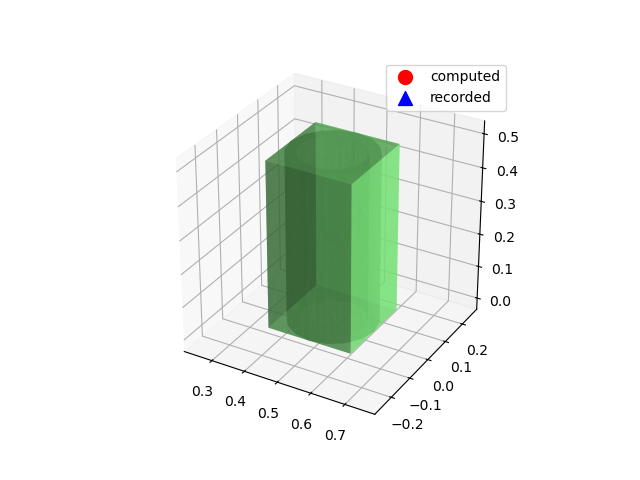

In [8]:
%matplotlib widget

obj_idx = 1
frame = '0000'
trim = trimesh.Trimesh(vertices=object_meshes[obj_idx][0], faces=object_meshes[obj_idx][1])
oriented_bbox = trim.bounding_box
bounding_box_b3d = b3d.Mesh.from_trimesh(oriented_bbox)

mesh_b3d = b3d.Mesh.from_trimesh(trim)

with h5py.File(hdf5_file_path, "r") as f:
    position = np.array(f['frames'][frame]['objects']['positions_cam0'])
    rotation = np.array(f['frames'][frame]['objects']['rotations_cam0'])
    object_pose = b3d.Pose(position[obj_idx], rotation[obj_idx])

    mesh_transform = mesh_b3d.transform(object_pose)
    mesh_transform = trimesh.Trimesh(mesh_transform.vertices, mesh_transform.faces)
    # Get the axis-aligned bounding box (AABB)
    bounding_box_transform = bounding_box_b3d.transform(object_pose)
    bounding_box_transform = trimesh.Trimesh(bounding_box_transform.vertices, bounding_box_transform.faces)

    # Compute the center of mass using trimesh's built-in function
    # center_of_mass = mesh_transform.center_mass
    # center_of_mass[[1,2]] = center_of_mass[[2,1]]
    center_of_mass = bounding_box_transform.center_mass
    center_of_mass[[1,2]] = center_of_mass[[2,1]]

    center_cam0 = np.array(f['frames'][frame]['objects']['center_cam0'])[obj_idx]
    center_cam0[[1,2]] = center_cam0[[2,1]]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.plot_trisurf(mesh_transform.vertices[:, 0], mesh_transform.vertices[:,2], mesh_transform.vertices[:,1], triangles=mesh_transform.faces, 
                    color=(0.5, 0.5, 0.5, 0.6))
    ax.plot_trisurf(bounding_box_transform.vertices[:, 0], bounding_box_transform.vertices[:,2], bounding_box_transform.vertices[:,1], triangles=bounding_box_transform.faces, 
                    color=(0.5, 1, 0.5, 0.6))
    ax.scatter(*center_of_mass, color='red', s=100, label='computed', marker='o')
    ax.scatter(*center_cam0, color='blue', s=100, label='recorded', marker='^')
    # Print the corners of the bounding box
    # for corner in oriented_bbox_corners:
    #     ax.scatter(*corner, color='green', s=100, marker='*')
    set_axes_equal(ax)
    plt.legend()
    plt.show()

In [9]:
center_cam0

array([4.9999729e-01, 4.2389247e-06, 2.5066552e-01], dtype=float32)

In [10]:
center_of_mass

array([4.99997294e-01, 4.22775823e-06, 2.50665505e-01])

/var/tmp/ipykernel_6781/2711862174.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


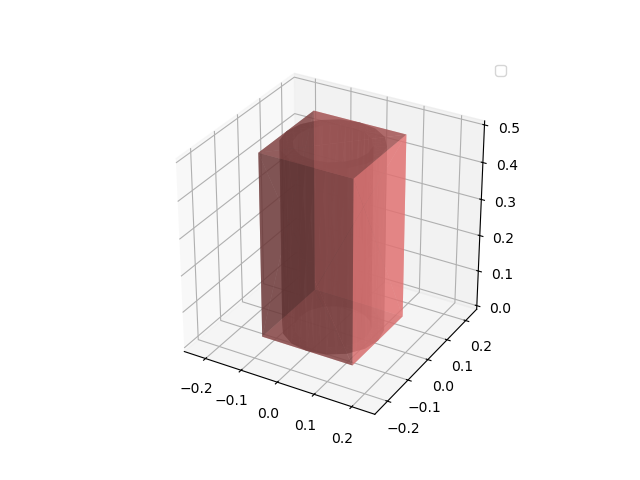

In [11]:
%matplotlib widget

obj_idx = 1
frame = '0000'
trim = trimesh.Trimesh(vertices=object_meshes[obj_idx][0], faces=object_meshes[obj_idx][1])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,1,1])
ax.plot_trisurf(trim.vertices[:, 0], trim.vertices[:,2], trim.vertices[:,1], triangles=trim.faces, 
                color=(0.5, 0.5, 0.5, 0.6))

oriented_bbox = trim.bounding_box
ax.plot_trisurf(oriented_bbox.vertices[:, 0], oriented_bbox.vertices[:,2], oriented_bbox.vertices[:,1], triangles=oriented_bbox.faces, 
                color=(1, 0.5, 0.5, 0.6))

# bounding_box_b3d = b3d.Mesh.from_trimesh(oriented_bbox)
# bounding_box_transform = bounding_box_b3d.transform(object_pose)
# bounding_box_transform = trimesh.Trimesh(bounding_box_transform.vertices, bounding_box_transform.faces)


# mesh_b3d = b3d.Mesh.from_trimesh(trim)

# with h5py.File(hdf5_file_path, "r") as f:
#     position = np.array(f['frames'][frame]['objects']['positions_cam0'])
#     rotation = np.array(f['frames'][frame]['objects']['rotations_cam0'])
#     object_pose = b3d.Pose(position[obj_idx], rotation[obj_idx])

#     mesh_transform = mesh_b3d.transform(object_pose)
#     mesh_transform = trimesh.Trimesh(mesh_transform.vertices, mesh_transform.faces)
#     # Get the axis-aligned bounding box (AABB)
#     oriented_bbox = mesh_transform.bounding_box
#     bounding_box_b3d = b3d.Mesh.from_trimesh(oriented_bbox)
#     bounding_box_transform = bounding_box_b3d.transform(object_pose)
#     bounding_box_transform = trimesh.Trimesh(bounding_box_transform.vertices, bounding_box_transform.faces)

#     # Compute the center of mass using trimesh's built-in function
#     center_of_mass = mesh_transform.center_mass
#     center_of_mass[[1,2]] = center_of_mass[[2,1]]

#     center_cam0 = np.array(f['frames'][frame]['objects']['center_cam0'])[obj_idx]
#     center_cam0[[1,2]] = center_cam0[[2,1]]

#     fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')
#     ax.set_box_aspect([1,1,1])
#     ax.plot_trisurf(mesh_transform.vertices[:, 0], mesh_transform.vertices[:,2], mesh_transform.vertices[:,1], triangles=mesh_transform.faces, 
#                     color=(0.5, 0.5, 0.5, 0.6))
#     ax.plot_trisurf(bounding_box_transform.vertices[:, 0], bounding_box_transform.vertices[:,2], bounding_box_transform.vertices[:,1], triangles=bounding_box_transform.faces, 
#                     color=(1, 0.5, 0.5, 0.6))
#     ax.scatter(*center_of_mass, color='red', s=100, label='computed', marker='o')
#     ax.scatter(*center_cam0, color='blue', s=100, label='recorded', marker='^')
    # Print the corners of the bounding box
    # for corner in oriented_bbox_corners:
    #     ax.scatter(*corner, color='green', s=100, marker='*')
set_axes_equal(ax)
plt.legend()
plt.show()